In [1]:
import numpy as np
import cv2 as cv
import cv2
from cv2 import aruco, cvtColor, COLOR_BGR2GRAY, LUT
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
from funktionen import *

In [2]:
imgs = glob("../../serie1/*.jpg")

In [3]:
aruco_dict = aruco.extendDictionary(32, 3)
parameter = aruco.DetectorParameters()
parameter.cornerRefinementMethod = aruco.CORNER_REFINE_SUBPIX
LUT_IN = [0, 158, 216, 255]
LUT_OUT = [0, 22, 80, 176]
lut = np.interp(np.arange(0, 256),
                LUT_IN, LUT_OUT).astype(np.uint8)

(2592, 4608, 3)


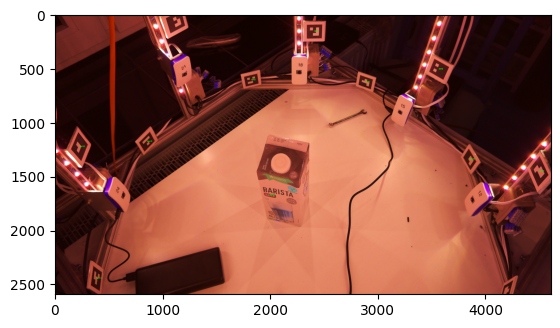

[[11]
 [13]
 [10]
 [15]
 [12]
 [13]
 [ 0]
 [ 3]
 [ 9]
 [ 2]]
(2592, 4608, 3)


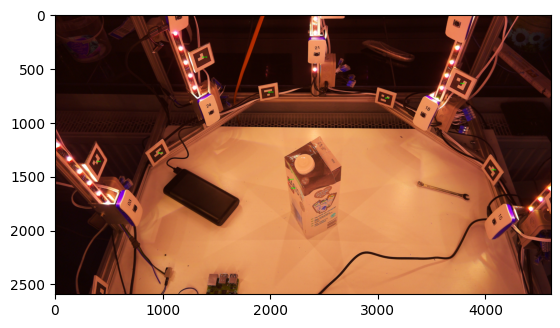

[[ 2]
 [17]
 [ 0]
 [ 5]
 [11]
 [ 3]
 [13]
 [ 2]
 [12]]


In [4]:
corners = []
for j, imgPfad in enumerate(imgs):
    imgCV = cv.imread(imgPfad)
    gray = cvtColor(imgCV, COLOR_BGR2GRAY)
    tmp_corners, tmp_ids, t = aruco.detectMarkers(
        gray, aruco_dict, parameters=parameter)
    if j == 6 or j == 3:
        mimg = aruco.drawDetectedMarkers(
            imgCV, tmp_corners, tmp_ids, (255, 0, 0))
        print(mimg.shape)
        plt.imshow(mimg)
        plt.show()
        print(tmp_ids)
        cv.imwrite("mimg.jpg", mimg)
    for c, i in zip(tmp_corners, tmp_ids):
        size = np.linalg.norm(c[0][0] - c[0][1])
        # print(size)
        if size < 100:
            continue
        for k in range(len(c[0])):
            corners.append([j, i[0], k, c[0][k][0], c[0][k][1]])

In [5]:
corners = pd.DataFrame(corners, columns=["img", "marker", "ecke", "x", "y"])
corners.set_index(["img", "marker", "ecke"], inplace=True)
corners

x            y
img marker ecke                          
0   0      0     1969.539429   297.320587
           1     1981.801514   407.178833
           2     1852.734985   430.239105
           3     1833.315918   321.256836
    13     0      194.009140  2110.138184
...                      ...          ...
23  9      3     1180.403442   830.981873
    16     0     4285.006836   910.371643
           1     4060.363281   929.256897
           2     4059.873535   723.031067
           3     4284.933105   693.774963

[440 rows x 2 columns]

In [55]:
ca = corners.reset_index().set_index(["marker", "ecke"])
matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query(
    'img_a < img_b').query("marker < 17")
matched.reset_index(inplace=True)
# matched.set_index(["img", "marker", "ecke"], inplace=True)
# matched.sort_index(inplace=True)
matched.query("img_a == 6").query("marker==2")

,marker,ecke,img_a,x_a,y_a,img_b,x_b,y_b
194,2,0,6,3799.874512,748.705566,7,4128.812012,676.566772
195,2,0,6,3799.874512,748.705566,8,4140.624512,1070.635742
196,2,0,6,3799.874512,748.705566,21,308.378052,1615.592041
222,2,1,6,3659.444580,674.151855,7,3927.174072,632.232971
223,2,1,6,3659.444580,674.151855,8,3918.454102,1091.867188
224,2,1,6,3659.444580,674.151855,21,230.379929,1772.498535
250,2,2,6,3716.038086,544.062317,7,3977.437744,434.501007
251,2,2,6,3716.038086,544.062317,8,3919.023193,892.570618
252,2,2,6,3716.038086,544.062317,21,118.660255,1652.270752
278,2,3,6,3862.410645,618.466492,7,4185.822754,472.525909


In [56]:
best = matched.groupby(['img_a', 'img_b'])['marker'].count()      .reset_index(name='count') \
    .sort_values(['count'], ascending=False)
best

,img_a,img_b,count
144,15,19,20
167,19,20,20
110,10,13,16
174,21,22,16
18,1,4,16
...,...,...,...
94,8,11,4
91,7,21,4
90,7,15,4
1,0,2,4


In [57]:
mtx = np.array([[3.48172482e+03, 0.00000000e+00, 2.30250916e+03],
                [0.00000000e+00, 3.47313834e+03, 1.31660435e+03],
                [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]])
dist = np.array([-1.41372220e-02,  2.43909839e-01,
                1.15659062e-03,  1.28627153e-04,  -5.96950573e-01])
kameras = pd.DataFrame([[1, mtx[0, 0], mtx[1, 1], mtx[0, 2], mtx[1, 2],
                        dist[ 0], dist[1], dist[2], dist[ 3], dist[4]]],
                       columns=["kamera", "fx", "fy", "cx", "cy", "d1", "d2", "d3", "d4", "d5"]).astype({"kamera": int}).set_index("kamera")
kameras

,fx,fy,cx,cy,d1,d2,d3,d4,d5
kamera,,,,,,,,,
1,3481.72482,3473.13834,2302.50916,1316.60435,-0.014137,0.24391,0.001157,0.000129,-0.596951


In [58]:
bild1 = best['img_a'].values[0]
bild2 = best['img_b'].values[0]
pts = matched.reset_index()\
    .query("img_a == " + str(bild1))\
    .query("img_b == " + str(bild2))[["marker", "ecke", "x_a", "y_a", "x_b", "y_b"]].values
pts1 = pts[:, 2:4].astype(np.float32)
pts2 = pts[:, 4:].astype(np.float32)
pids = pts[:, :2].astype(np.float32)
len(pts1)

20

In [59]:
K1 = mtx
K2 = mtx

points1 = cart2hom(np.array(pts1).T)
points2 = cart2hom(np.array(pts2).T)

# Calculate essential matrix with 2d points.
# Result will be up to a scale
# First, normalize points
# Hartley p257
points1n = np.dot(np.linalg.inv(K1), points1)
points2n = np.dot(np.linalg.inv(K2), points2)
# cv2.undistortPoints(pts1, intrinsic, None)[:,0,:].T

print(len(points1n.T))

maxcount = 0
maxauswahl: NDArray[Any] | None = None

for i in range(1000):
    auswahl = choices(range(len(pts1)), k=8)

    E = compute_essential_normalized(
        points1n[:, auswahl], points2n[:, auswahl])

    mask = np.array([abs(points2n.T[i].T@E@points1n.T[i]) < 1
                    for i in range(len(points2n.T))])

    count = len(points2n.T[mask])
    if count > maxcount:
        maxcount = count
        maxauswahl = mask

points1n = points1n.T[maxauswahl].T
points2n = points2n.T[maxauswahl].T
pids = pids[maxauswahl]

E = compute_essential_normalized(points1n, points2n)

print('Computed essential matrix:', (-E / E[0][1]))

20
Computed essential matrix: [[ 1.1495271  -1.          0.87815277]
 [ 0.61902414 -0.61378127 -2.48722025]
 [-1.26632103  1.12025982 -0.23369351]]


In [60]:
P1 = np.array([[1, 0, 0, 0], [0, 1, 0, 0], [0, 0, 1, 0]], dtype=np.float32)
R1 = P1[:, :3]
t1 = P1[:, 3]
rod1, _ = cv2.Rodrigues(R1)

_, R, t, mask = cv2.recoverPose(E, points1n[:2].T, points2n[:2].T, np.eye(3))

R = np.linalg.inv(R)
t = -R@t

rod, _ = cv2.Rodrigues(R)

P2 = np.c_[R, t]
print(P2)

print(len(points1n.T))

[[ 0.71018707 -0.58204005  0.39606023 -0.66443642]
 [ 0.26844095  0.74395193  0.61194361 -0.74710325]
 [-0.65082546 -0.32827566  0.68458843  0.01899944]]
20


In [61]:
pictures = pd.DataFrame([[bild1, 0, 0, 0, 0, 0, 0], [
                        bild2, t[0][0], t[1][0], t[2][0], rod[0][0], rod[1][0], rod[2][0]]], columns=["img", "x", "y", "z", "r1", "r2", "r3"]).set_index("img")
# np.c_[t.T,rod.T]
pictures

,x,y,z,r1,r2,r3
img,,,,,,
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,-0.664436,-0.747103,0.018999,-0.551872,0.614481,0.499199


In [62]:
mask = mask.ravel()
pids = pids[mask == 255]
points1n = points1n.T[mask == 255].T
points2n = points2n.T[mask == 255].T

In [63]:
tripoints3d = reconstruct_points(points1n, points2n, P1, P2)
# tripoints3d = structure.linear_triangulation(points1n, points2n, P1, P2)
tripoints3d /= tripoints3d[3]

In [64]:
coords = pd.DataFrame(list(zip(pids.T[0], pids.T[1], tripoints3d[0], tripoints3d[1],
                               tripoints3d[2])), columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"]).sort_index()

In [65]:
laenge = np.linalg.norm(coords.query("marker == 0").query("ecke == 0")[
    ["x", "y", "z"]].values - coords.query("marker == 0").query("ecke == 1")[["x", "y", "z"]].values)
if laenge > 0.0001:
    faktor = 0.034 / laenge

    coords["x"] *= faktor
    coords["y"] *= faktor
    coords["z"] *= faktor

    pictures["x"] *= faktor
    pictures["y"] *= faktor
    pictures["z"] *= faktor

In [66]:
# pip install plotly

import plotly.graph_objs as go


# Create a 3D scatter plot
fig = go.Figure(data=[go.Scatter3d(x=coords['x'], y=coords['y'], z=coords['z'], mode='markers', name='Original Points'),
                      go.Scatter3d(x=pictures['x'], y=pictures['y'], z=pictures['z'],
                                   mode='markers', name='Kameras')])

# Add labels to the plot
fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                  title='Rotation and Translation Vectors in 3D')

fig.show()

### Ausgleichung

In [67]:
def ausgleichung():
    global coords, pictures, kameras
    lp = corners.join(coords, lsuffix="_img", rsuffix="").query(
     "marker < 17").join(pictures, lsuffix="", rsuffix="_cam").dropna()

    kamera = kameras.reset_index().values
    kamera_ids = np.array(kamera[:, 0], dtype=np.int32)

    bilder = pictures.reset_index().values
    bilder = np.c_[np.ones(len(bilder)), bilder]
    bilder_ids = np.array(bilder[:, :2], dtype=np.int32)

    passpunkte = coords.reset_index().values
    passpunkte_ids = np.array(passpunkte[:, :2], dtype=np.int32)

    messung = lp.reset_index().values[:, :5]
    messung_ids = np.array(messung[:, :3], dtype=np.int32)
    from scipy.sparse import lil_matrix
    from scipy.optimize import least_squares
    l = np.array(messung[:, -2:].ravel(), dtype=np.float64)

    x0 = np.hstack((kamera[:, 1:].ravel(),
                    bilder[:, 2:].ravel(), passpunkte[:, 2:].ravel()))

    A = lil_matrix((len(l), len(x0)), dtype=int)

    n_camera = len(kamera)
    n_bilder = len(bilder)
    n_passpunkte = len(passpunkte)
    n_messungen = len(messung)
    messung_bild_id = np.empty(n_messungen, dtype=np.int32)
    messung_kamera_id = np.empty(n_messungen, dtype=np.int32)
    messung_passpunkt_id = np.empty(n_messungen, dtype=np.int32)
    num_cam_param = 9
    num_bild_param = 6
    num_pass_param = 3

    for i, m in enumerate(messung):
        bild_id, = np.where(bilder_ids[:, 1] == m[2])
        bild_id = bild_id[0]
        messung_bild_id[i] = bild_id

        camera_id_array,  = np.where(kamera_ids[:] == bilder[bild_id, 0])
        camera_id = camera_id_array[0]
        messung_kamera_id[i] = camera_id

        passpunkt_id_array, = np.where(
            (passpunkte_ids[:, 0] == m[0]) & (passpunkte_ids[:, 1] == m[1]))
        passpunkt_id = passpunkt_id_array[0]
        messung_passpunkt_id[i] = passpunkt_id

        offset = camera_id*num_cam_param
        A[2*i:2*i+2, offset:offset+num_cam_param] = 1

        offset = n_camera * num_cam_param + bild_id * num_bild_param
        A[2*i:2*i+2, offset:offset + num_bild_param] = 1

        offset = n_camera*num_cam_param + n_bilder * \
            num_bild_param + passpunkt_id * num_pass_param
        A[2*i:2*i+2, offset:offset + num_pass_param] = 1

    def project(x0: NDArray[np.float32]) -> NDArray[np.float32]:
        p = np.empty(len(l), dtype=np.float32)

        K = []
        dist = []
        for i in range(n_camera):
            offset = i * num_cam_param
            fx = x0[offset]
            fy = x0[offset + 1]
            cx = x0[offset + 2]
            cy = x0[offset + 3]
            K.append(np.array([[fx, 0, cx], [0, fy, cy], [0, 0, 1]]))
            dist.append(np.array([x0[offset + 4], x0[offset + 5],
                                x0[offset + 6], x0[offset + 7], x0[offset + 8]]))

        r = []
        t = []
        for i in range(n_bilder):
            offset = n_camera * num_cam_param + \
                i*num_bild_param

            t.append(x0[offset:offset+3])
            r.append(x0[offset+3:offset+6])

        X = []
        for i in range(n_passpunkte):
            offset = n_camera * num_cam_param + \
                n_bilder*num_bild_param + \
                num_pass_param * i
            X.append(x0[offset:offset+3].reshape(1, 3))

        for i, m in enumerate(messung):
            punkt, _ = cv2.projectPoints(
                X[messung_passpunkt_id[i]], r[messung_bild_id[i]], t[messung_bild_id[i]], K[messung_kamera_id[i]], dist[messung_kamera_id[i]])
            # print(i*2+1)
            p[i*2] = punkt[0, 0, 0]
            p[i*2+1] = punkt[0, 0, 1]

        return p.ravel()-l

    res = least_squares(project, x0, jac_sparsity=A, verbose=2, 
                        x_scale='jac', method='trf', ftol=1e-3)  # type: ignore

    x = res.x

    kameras = pd.DataFrame(np.c_[kamera_ids, x[:num_cam_param * n_camera].reshape(n_camera, num_cam_param)],
                        columns=["kamera", "fx", "fy", "cx", "cy", "d1", "d2", "d3", "d4", "d5"]).astype({"kamera": int}).set_index("kamera")

    offset = num_cam_param * n_camera
    pictures = pd.DataFrame(np.c_[bilder_ids[:, 1], x[offset:offset+num_bild_param*n_bilder].reshape(
        n_bilder, num_bild_param)], columns=["img", "x", "y", "z", "r1", "r2", "r3"]).astype({"img": int}).set_index("img")

    offset = num_cam_param * n_camera + num_bild_param*n_bilder
    coords = pd.DataFrame(np.c_[passpunkte_ids, x[offset:offset+num_pass_param*n_passpunkte].reshape(n_passpunkte, num_pass_param)],
                        columns=["marker", "ecke", "x", "y", "z"]).astype({"marker": int, "ecke": int}).set_index(["marker", "ecke"])
    return res

In [68]:
def wolke_zeigen():
    global coords, pictures, kameras
    # pip install plotly

    import plotly.graph_objs as go


    # Create a 3D scatter plot
    fig = go.Figure(data=[go.Scatter3d(x=coords['x'], y=coords['y'], z=coords['z'], mode='markers', name='Original Points'),
                        go.Scatter3d(x=-pictures['x'], y=-pictures['y'], z=pictures['z'],
                                    mode='markers', name='Kameras')])

    # Add labels to the plot
    fig.update_layout(scene=dict(xaxis_title='X', yaxis_title='Y', zaxis_title='Z'),
                    title='Rotation and Translation Vectors in 3D')

    fig.show()

In [69]:
# pictures.drop(pictures.index, inplace=True)
pictures

,x,y,z,r1,r2,r3
img,,,,,,
15,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
19,-0.664436,-0.747103,0.018999,-0.551872,0.614481,0.499199


#### Neue Bilder

In [70]:
def neues_bild():
    global coords, pictures, kameras
    lp = corners.join(coords, lsuffix="_img", rsuffix="").query(
        "marker < 17").dropna().join(pictures, lsuffix="", rsuffix="_cam")
    lp = lp[lp["r1"].isnull()]
    bild = lp.groupby("img").count().sort_values(
        "x_img", ascending=False).first_valid_index()
    passpunkte = lp.query('img == ' + str(bild)).reset_index()
    pp = passpunkte[['x_img', 'y_img', 'x', 'y', 'z']].values
    _, r, t, _ = cv2.solvePnPRansac(pp[:, 2:], pp[:, :2], mtx, None)
    rod, _ = cv2.Rodrigues(r)
    pictures = pd.concat([pictures, pd.DataFrame([[bild, t[0][0], t[1][0], t[2][0], r[0][0], r[1][0], r[2][0]]], columns=[
        "img", "x", "y", "z", "r1", "r2", "r3"]).set_index("img")])

In [71]:
def zeige_auf_bildern():
    global coords, pictures, kameras
    for nr in pictures.index:
        print(nr)
        imgCV = cv.imread(imgs[nr])
        r = pictures.query("img == "+str(nr))[["r1", "r2", "r3"]].values
        t = pictures.query("img == "+str(nr))[["x", "y", "z"]].values
        kp = kameras.query("kamera == 1").values
        mtx = np.array([[kp[0][0], 0, kp[0][2]], [
                    0, kp[0][1], kp[0][3]], [0, 0, 1]])
        dist = kp[0][4:]
        img_points, _ = cv2.projectPoints(coords.values, r, t, mtx, dist)
        for p in img_points:
            try:
                cv2.circle(imgCV, (int(p[0][0]), int(p[0][1])), 30, (0, 0, 255), -1)
            except:
                pass
        plt.imshow(imgCV)
        plt.show()

In [72]:
def neue_koordinaten():
    global coords, pictures, kameras
    pic_a = pictures.reset_index().rename(
        columns={"img": "img_a"}).set_index("img_a")
    pic_b = pictures.reset_index().rename(
        columns={"img": "img_b"}).set_index("img_b")
    matched = ca.join(ca, lsuffix="_a", rsuffix="_b").query(
        'img_a < img_b').query("marker < 17").join(coords, lsuffix="", rsuffix="_ca")
    matched = matched[matched["x"].isnull()].reset_index().set_index([
        "img_a", "img_b"])
    matched = matched.join(pic_a, lsuffix="", rsuffix="_pic_a")
    matched = matched.join(pic_b, lsuffix="", rsuffix="_pic_b")
    matched.dropna(subset=['x_pic_a', 'x_pic_b'], inplace=True)
    matched = matched.reset_index().set_index(["marker", "ecke"])

    bester = matched.groupby(["marker"]).count().sort_values(
        "img_a", ascending=False).first_valid_index()

    K = mtx

    for i in range(4):
        cneu = []
        for v in matched.query("marker =="+str(bester)).query("ecke =="+str(i))[['x_pic_a', 'y_pic_a', 'z_pic_a', 'r1', 'r2', 'r3', 'x_pic_b', 'y_pic_b', 'z_pic_b', 'r1_pic_b', 'r2_pic_b', 'r3_pic_b', 'x_a',	'y_a',	'x_b', 'y_b']].values:
            R1 = cv2.Rodrigues(v[3:6])[0]
            R2 = cv2.Rodrigues(v[9:12])[0]
            t1 = v[0:3]
            t2 = v[6:9]
            P1 = np.c_[R1, t1]
            P2 = np.c_[R2, t2]
            pt1 = v[12:14]
            pt2 = v[14:16]
            p1n = np.dot(np.linalg.inv(K), cart2hom(pt1))
            p2n = np.dot(np.linalg.inv(K), cart2hom(pt2))
            xy = reconstruct_one_point(p1n, p2n, P1, P2)
            xy /= xy[3]
            cneu.append(xy[0:3])
        if len(cneu) == 0:
            print("nichts")
            continue
        mean = pd.DataFrame(cneu, columns=["x", "y", "z"]).median().values
        new = pd.DataFrame([[bester, i, mean[0], mean[1], mean[2]]], columns=["marker", "ecke", "x", "y", "z"]).set_index(["marker", "ecke"])
        coords = pd.concat([coords, new])
        
        

In [73]:
neue_koordinaten()


nichts
nichts
nichts
nichts


In [86]:
ausgleichung()
wolke_zeigen()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()
neue_koordinaten()
ausgleichung()
ausgleichung()
neues_bild()
ausgleichung()
ausgleichung()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3574e+03                                    1.83e+04    
       1             18         1.3574e+03      0.00e+00       0.00e+00       1.83e+04    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 1.3574e+03, final cost 1.3574e+03, first-order optimality 1.83e+04.


nichts
nichts
nichts
nichts
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3574e+03                                    1.83e+04    
       1             18         1.3574e+03      0.00e+00       0.00e+00       1.83e+04    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 1.3574e+03, final cost 1.3574e+03, first-order optimality 1.83e+04.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.3574e+03                                    1.83e+04    
       1             18         1.3574e+03      0.00e+00       0.00e+00       1.83e+04    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 1.3574e+03, final cost 1.3574e+03, first-order optimality 1.83e+04.
   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.367

error: OpenCV(4.8.1) /io/opencv/modules/calib3d/src/solvepnp.cpp:227: error: (-215:Assertion failed) npoints >= 4 && npoints == std::max(ipoints.checkVector(2, CV_32F), ipoints.checkVector(2, CV_64F)) in function 'solvePnPRansac'


In [83]:
wolke_zeigen()
kameras

,fx,fy,cx,cy,d1,d2,d3,d4,d5
kamera,,,,,,,,,
1,3481.886079,3463.826094,2302.528798,1316.256969,-0.013461,0.248837,0.001099,0.000095,-0.55697


15


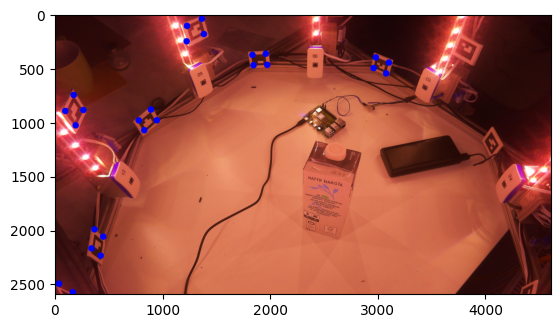

19


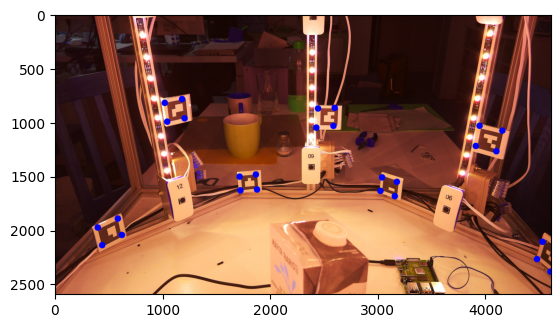

20


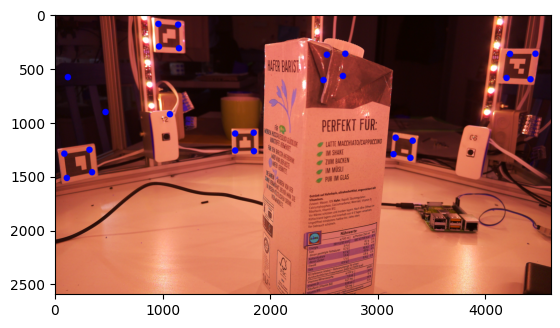

22


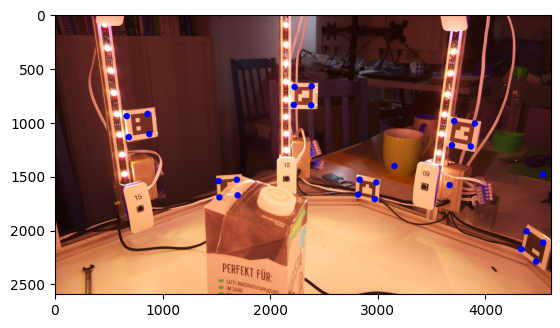

16


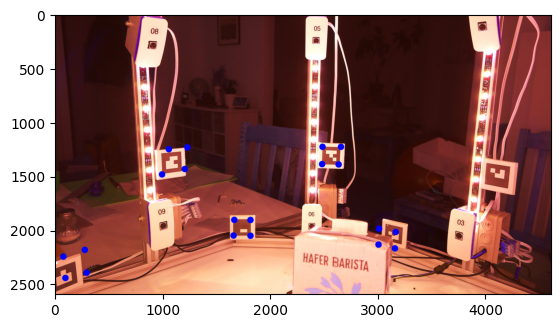

18


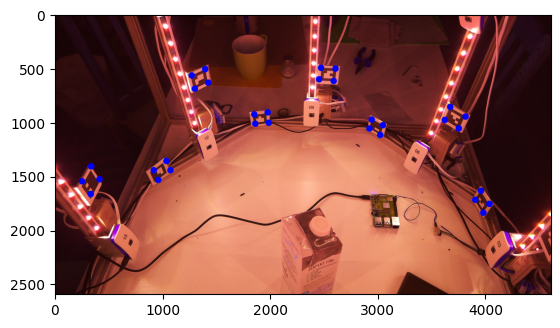

21


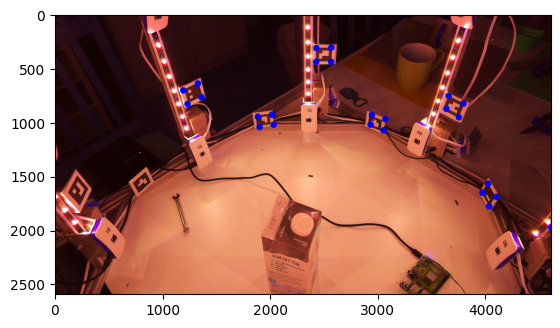

1


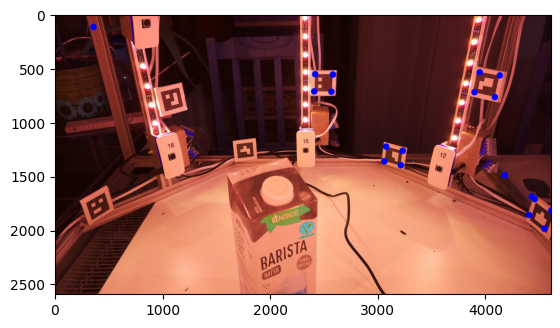

In [76]:
zeige_auf_bildern()

In [89]:
res_lsq = ausgleichung()

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.4464e+03                                    1.79e+04    
       1             18         1.4464e+03      0.00e+00       0.00e+00       1.79e+04    
`xtol` termination condition is satisfied.
Function evaluations 18, initial cost 1.4464e+03, final cost 1.4464e+03, first-order optimality 1.79e+04.


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.